# G03: “Predict Travel Mode Choices: A comparison of the performance of machine learning classifiers”

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 1. Introduction


We aim to accomplist the following for this project. 

The data is from a survey of The Netherlands Mobility Panel (MPN) studies trends in the travel behaviour of a fixed group of individuals and households;


* Build a prediction model that will perform the following:

- Train a Multinomial logistic regression, SVM and Random Forest  for classification, from a survey of The Netherlands Mobility Panel (MPN) studies trends in the travel behaviour of a fixed group of individuals and households;


- To evaluate the models compute: A comparison will be made between multinomial logistic regression, multiclass Classification with Support Vector Machines (SVM), and random forest to determine the methods that most accurately predict travel mode choice


**Run the code cell below** to import the required packages.

In [1]:
import time
import sklearn
import numpy as np
import pandas as pd
import os
import yaml

import util.general
import util.catalogue
import util.storage
import util.cleansing
import util.plotting
import preprocessing.report
import preprocessing.cleansing
import preprocessing.fselection
import preprocessing.preparation
import training.analysis
import training.training_rf
import training.training_lr
import training.training_svm
import training.plotting

In [2]:
# folder to load config file
CONFIG_PATH = "./"

# Function to load yaml configuration file
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)

    return config

config = load_config("environment.yaml")
print(config)

{'data_directory': './data/', 'data_name': 'mobility_dataset.csv', 'catalogue_name': 'catalogue.csv', 'drop_columns': ['HHID', 'PERSID', 'VPLID', 'RitID', 'HH_VALID', 'P_VALID'], 'target_name': 'KHVM', 'number_splits': 1, 'test_size': 0.3, 'random_state': 42}


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 2. Data set review and prepaparation

Data from from a survey (2018) he Netherlands Mobility Panel (MPN) studies trends in the travel behaviour of a fixed group of individuals and households; 

<div style="border-bottom: 3px solid black;"></div>

### 2.1  Get the Data from a CSV file

We will use data from residences from North-Holland of the The Netherlands.


In [3]:
# load dataset
data = preprocessing.preparation.read_csv(config['data_directory'] + config['data_name'])
data.head(10)

,HHID,PERSID,VPLID,RitID,HH_VALID,P_VALID,KHVM,WEGGEWEEST,VERTREKP,AANTVPL,...,HHAUTO_N,HHAUTO,HHBESTEL,HHHYBRID,HHMOTOR,HHBROM,HHSNOR,HHFIETS,HHVOUWFIETS,HHEBIKE
0,30055622,3005562201,13957101,1395710101,2,3,2,1,2,2,...,3,1,0,0,1,0,0,1,0,1
1,30055622,3005562201,13957102,1395710201,2,3,2,1,2,2,...,3,1,0,0,1,0,0,1,0,1
2,30055622,3005562201,13957201,1395720101,2,3,1,1,2,4,...,3,1,0,0,1,0,0,1,0,1
3,30055622,3005562201,13957202,1395720201,2,3,1,1,2,4,...,3,1,0,0,1,0,0,1,0,1
4,30204076,3020407601,14445303,1444530301,2,3,8,1,1,3,...,2,1,1,0,1,0,0,1,0,1
5,30204076,3020407601,14445303,1444530302,2,3,8,1,1,3,...,2,1,1,0,1,0,0,1,0,1
6,30204076,3020407601,14445303,1444530303,2,3,8,1,1,3,...,2,1,1,0,1,0,0,1,0,1
7,30356310,3035631001,17204101,1720410101,2,3,8,1,2,1,...,2,1,0,0,0,0,0,0,0,1
8,30356310,3035631001,17204101,1720410102,2,3,8,1,2,1,...,2,1,0,0,0,0,0,0,0,1
9,30356310,3035631001,17204101,1720410103,2,3,8,1,2,1,...,2,1,0,0,0,0,0,0,0,1


<div style="border-bottom: 3px solid black;"></div>

The dataset is tabular data. The features in the dataset are categorical,  where the variables are categorically divided in an ordinal and nominal manner. 

In this case, the data was gotten through a survey conducted by a group of individuals, who were asked to identify their principal travel mode choices.

That's why to know the values and description of those variables, we have a catalogued dataset with details of them.

Below, we will load the catalogue and then create functions to get the labels and values of the categorical variables.

In [4]:
# load catalogue: contains the description of the each level from ordinal and nominal variables 
catalogue  = preprocessing.preparation.read_csv(config['data_directory'] + config['catalogue_name'])
catalogue.head(10)

,Variable,Var_description,Value,Label,Measurement_level,BaseData_Type,Name_BaseData,Filter_Variables
0,PERSOON,new person,0,no new person,Nominal,Mobility,MPNWAVE6_DAGBOEKdata,1
1,PERSOON,new person,1,new person,Nominal,Mobility,MPNWAVE6_DAGBOEKdata,1
2,HHID,Unique Household ID,999999999,Input,Scale,Mobility,MPNWAVE6_DAGBOEKdata,1
3,PERSID,Unique ID of Person,999999999,Unique ID of Person,Scale,Mobility,MPNWAVE6_DAGBOEKdata,1
4,HH_VALID,Complete household yes or no,0,"Not a complete household, not all persons comp...",Nominal,Mobility,MPNWAVE6_DAGBOEKdata,1
5,HH_VALID,Complete household yes or no,1,"Not a complete household, but all persons comp...",Nominal,Mobility,MPNWAVE6_DAGBOEKdata,1
6,HH_VALID,Complete household yes or no,2,Yes a complete household,Nominal,Mobility,MPNWAVE6_DAGBOEKdata,1
7,HH_VALID,Complete household yes or no,3,No household questionnaire,Nominal,Mobility,MPNWAVE6_DAGBOEKdata,1
8,IMPHHDATA,Imputation household characteristics,0,"no household questionnaire, did not participat...",Nominal,Mobility,MPNWAVE6_DAGBOEKdata,0
9,IMPHHDATA,Imputation household characteristics,1,"no household questionnaire, imputation of hous...",Nominal,Mobility,MPNWAVE6_DAGBOEKdata,0


In [5]:
# Deleting HHID, PERSID, VPLID and RItID columns
# These variables that are of type ID are removed
data = data.drop(config['drop_columns'], axis=1)
data.head()

,KHVM,WEGGEWEEST,VERTREKP,AANTVPL,VPLDAGNR,VERPL,VERPLNR,TOER,TOER_TYPE,AANTRIT,...,HHAUTO_N,HHAUTO,HHBESTEL,HHHYBRID,HHMOTOR,HHBROM,HHSNOR,HHFIETS,HHVOUWFIETS,HHEBIKE
0,2,1,2,2,1,3,1,0,9,1,...,3,1,0,0,1,0,0,1,0,1
1,2,1,2,2,1,3,2,0,9,1,...,3,1,0,0,1,0,0,1,0,1
2,1,1,2,4,2,3,1,0,9,1,...,3,1,0,0,1,0,0,1,0,1
3,1,1,2,4,2,3,2,0,9,1,...,3,1,0,0,1,0,0,1,0,1
4,8,1,1,3,3,3,3,0,9,3,...,2,1,1,0,1,0,0,1,0,1


<div style="border-bottom: 3px solid black;"></div>

### 2.2 Take a Quick Look at the Data Structure

In [6]:
# replaces whitespaces with NaN to identify missing values
data = util.cleansing.replaceWhitespaceToNan(data)
# A quick description of the Data
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7310 entries, 0 to 7309
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   KHVM                     7310 non-null   int64 
 1   WEGGEWEEST               7310 non-null   int64 
 2   VERTREKP                 7310 non-null   int64 
 3   AANTVPL                  7310 non-null   int64 
 4   VPLDAGNR                 7310 non-null   int64 
 5   VERPL                    7310 non-null   int64 
 6   VERPLNR                  7310 non-null   int64 
 7   TOER                     7310 non-null   int64 
 8   TOER_TYPE                7310 non-null   int64 
 9   AANTRIT                  7310 non-null   int64 
 10  KMOTIEF                  7310 non-null   int64 
 11  VERTPROV                 7310 non-null   int64 
 12  AANKPROV                 7310 non-null   int64 
 13  KAFSTV                   7310 non-null   int64 
 14  KVERTTIJD                7310 non-null  

We can see that "KREISDUUR" and "ROLAUTO" have missing values

<div style="border-bottom: 3px solid black;"></div>

### 2.3 Data Cleaning : Dealing with missing values

The variable KREISDUUR has 81 missing values and PARKEERKOSTEN has 21 missing values. 

To deal with these missing values, we will set the values to its modes, givin the variables are ordinal and nominal type.


In [7]:
preprocessing.cleansing.cleaning_data(data);
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7310 entries, 0 to 7309
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   KHVM                     7310 non-null   int64
 1   WEGGEWEEST               7310 non-null   int64
 2   VERTREKP                 7310 non-null   int64
 3   AANTVPL                  7310 non-null   int64
 4   VPLDAGNR                 7310 non-null   int64
 5   VERPL                    7310 non-null   int64
 6   VERPLNR                  7310 non-null   int64
 7   TOER                     7310 non-null   int64
 8   TOER_TYPE                7310 non-null   int64
 9   AANTRIT                  7310 non-null   int64
 10  KMOTIEF                  7310 non-null   int64
 11  VERTPROV                 7310 non-null   int64
 12  AANKPROV                 7310 non-null   int64
 13  KAFSTV                   7310 non-null   int64
 14  KVERTTIJD                7310 non-null   int64
 15  KREI

Now the data set is clean!

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 3. Exploratory Data Analysis

Here our main interest is to get an understanding as to how the given attributes relate too the 'KHVM' variable, that provide the main transport mode trip of the individuals

### 3.1  Proportion of travel mode choices of travellers (Target Variable: Y_i)

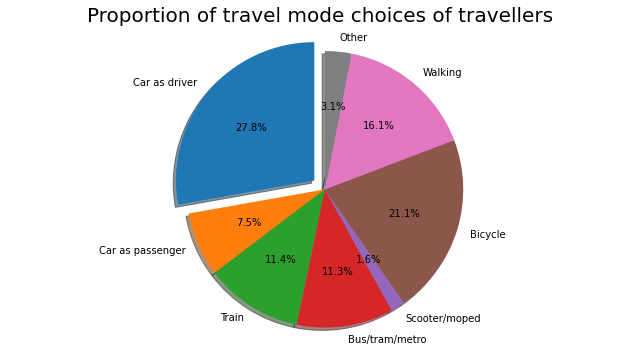

In [8]:
preprocessing.report.plot_travel_mode_pie(catalogue, data);

<div style="border-bottom: 3px solid black;"></div>

***Behavioral analysis of travel mode choice***

The graph shows the travelers' preferences. We find that the most used modes of transport in the state of North-Holland are: private car (car as a driver) 27.8%, bicycle 21.1, walking 16.1, train 11.4% and bus / tram / metro 11.3%.

### 3.2 Feature Selection 

***3.2.1 Selecting a Specific number of features***

link: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest

The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

Select features according to the k highest scores.

Function taking two arrays X and y, and returning a pair of arrays (scores, pvalues) or a single array with scores. 

In [9]:
df_X, df_y = preprocessing.fselection.get_features_target(data);
feature_Scores = preprocessing.fselection.get_best_features(df_X, df_y)
util.plotting.show_first_n_dataframe(feature_Scores,25,'Score')

,Feature,Score
12,KAFSTV,8589.395047
15,ROLAUTO,6745.369093
8,AANTRIT,6154.015586
14,KREISDUUR,4476.399225
16,PARKEERKOSTEN,1090.655985
17,VERTRAGING,945.821874
6,TOER,900.669860
4,VERPL,802.238690
9,KMOTIEF,710.784998
2,AANTVPL,700.007500


We can see, the best 25 using score function: chi-squared (through SelectKBest class that the scikit-learn library provides)

***3.2.2 Correlation Matrix with Heatmap***

Saving figure Correlation_Matrix_TargetvsFeatures


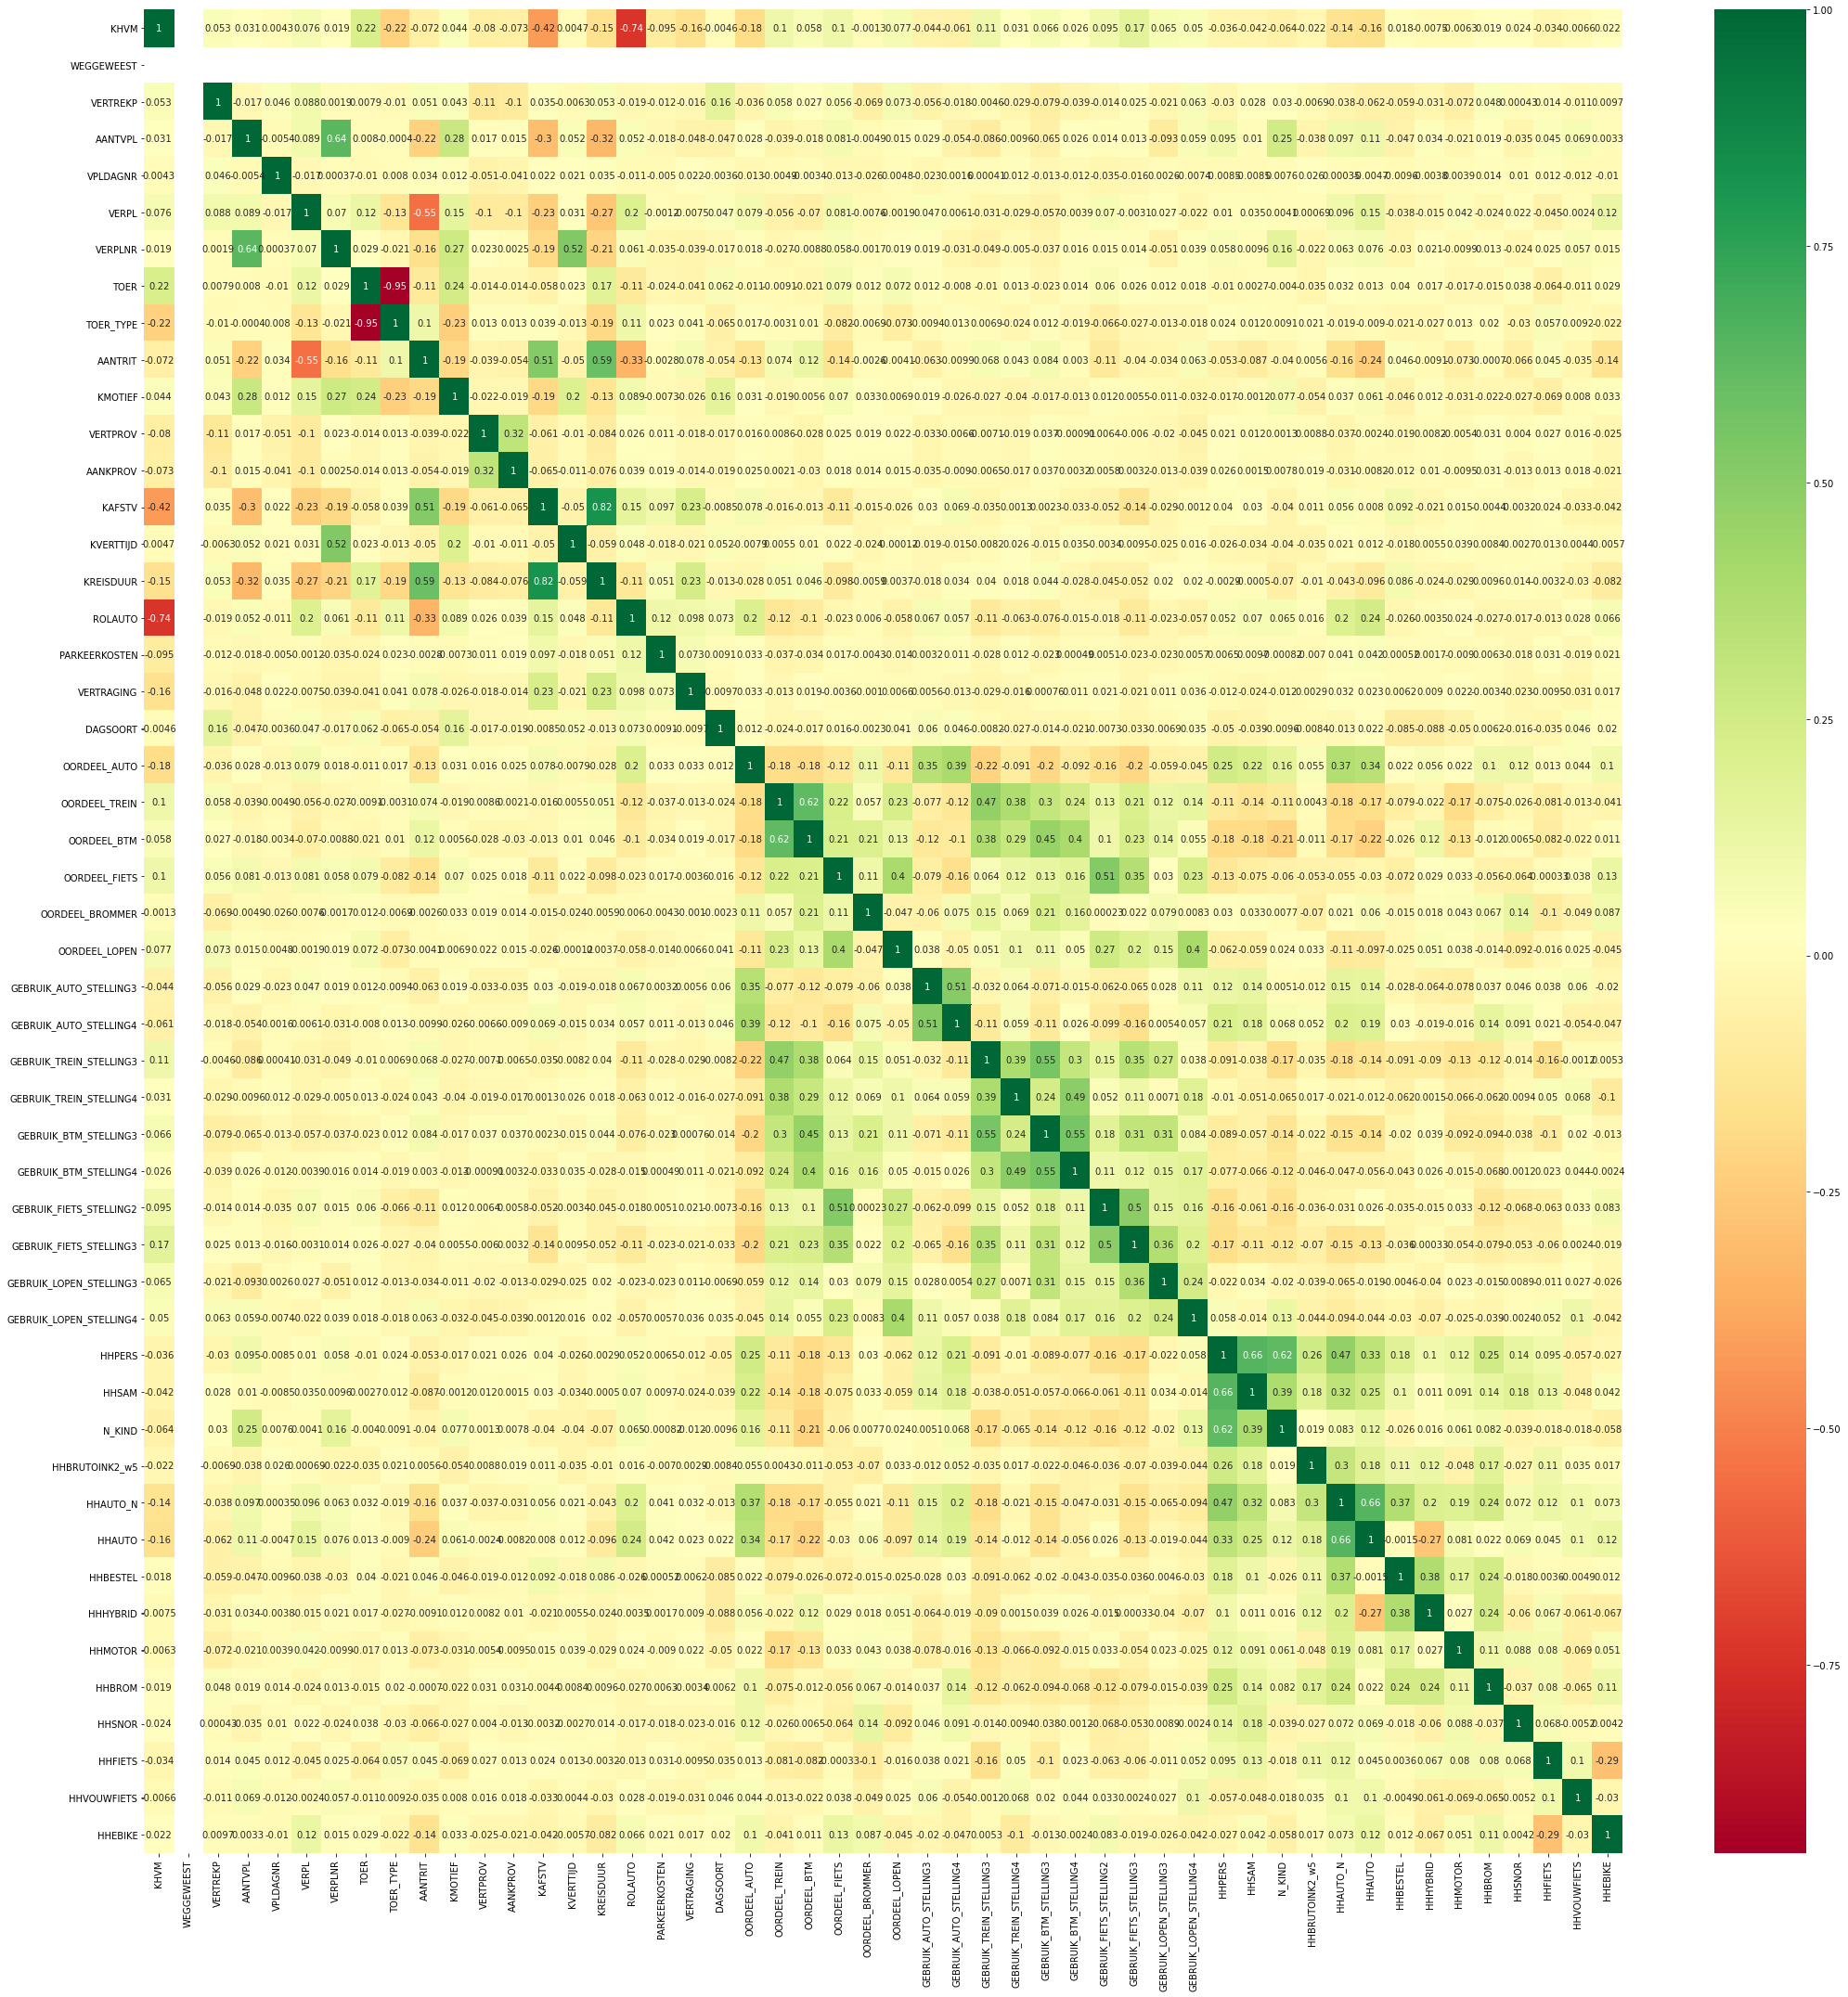

In [10]:
preprocessing.fselection.show_correlation_matrix(data);

Have a look at the last row i.e *"KHVM" (target variable)*, see how the **KHVM** is correlated with other features. For example ROLAUTO:("Role in car trip"), it means if a individual is the driver or passenger, in case that the individual is a passenger, it means that he/she uses a car like a vehicle-share services. Followed by **KAFSTV:	Distance class trip**, it makes sense,  **TOER_TYPE	Round trip type**  and  **OORDEEL_BROMMER	Personal impression of the moped, scooter** seems to be least correlated with **KHVM (target variable)**


***3.2.3 Selecting relevant features from data, to use how our features variables in the models that we will applied***


In [11]:
# to get the names of the best features 
best_features= feature_Scores.nlargest(25,'Score').iloc[:,0].to_numpy().reshape(-1)

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 4. Prepare the Data for Machine Learning Algorithms

We first split the train and test sets

Given the ***'KHVM' (Main transport mode class trip)*** is our target variable. To ensure that the test set is representative if the various categories of travel mode choices of travelers in the whole dataset.

These categories are represented in the previous figure.

* ***Sampling in stratified way: 70% train set and 30% test set:***

In [12]:
# To do stratefied sampling bases on the Main transport mode class trip category.
strat_train, strat_test = preprocessing.preparation.get_stratified_split(data, 
                                                                         config['target_name'], 
                                                                         config['number_splits'], 
                                                                         config['test_size'], 
                                                                         config['random_state'])

Looking at the proportion of travel mode choices of traverlers in the test set:

***Measure the proportion of travel mode choices of traverlers***


In [13]:
train_set, test_set = preprocessing.preparation.train_test_split(data, test_size=0.3)
compare_proportions = preprocessing.preparation.get_proportions_comparison(data,strat_test,test_set, config['target_name'])
compare_proportions

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.277975,0.278158,0.277246,-0.262467,0.065617
2,0.075239,0.075239,0.088007,16.969697,0.000000
3,0.114090,0.113999,0.103967,-8.872902,-0.079936
4,0.112996,0.113087,0.118103,4.519774,0.080710
5,0.016416,0.016416,0.011400,-30.555556,0.000000
6,0.211218,0.211126,0.213862,1.252159,-0.043178
7,0.161149,0.160967,0.156407,-2.942841,-0.113186
8,0.030917,0.031008,0.031008,0.294985,0.294985


The above table compares the proportion of travel mode choices of travellers in the overall dataset, in the test set generated with stratified sampling and the test set generated in a random sampling way.

We can see that the test set generated using stratified sampling has a proportion of travel mode choices of travellers almost identical to those of in the full dataset, and the test set generated in a random sampling way is skewed.


<div style="border-bottom: 3px solid black;"></div>

#### 4.1 ***Converting our train and test data frame to NumPy array***

In [14]:
X, y = preprocessing.preparation.convert_data_numpy(data)

**Getting X_train, y_train, X_test, y_test**

In [15]:
X_train, y_train, X_test, y_test = preprocessing.preparation.get_training_test_data(strat_train, strat_test)

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 5. Applying ML Models



# <div style="border-bottom: 3px solid black;"></div>

### 5.1 Random Forest Model

##### Use K-fold cross-validation to estimate held-out performance

In [16]:
rnd_clf, accuracy_train, accuracy_test, cv_accuracy = training.training_rf.get_cross_validation(10, 
                                                                                                X_train, 
                                                                                                y_train,
                                                                                                X_test, 
                                                                                                y_test);

**Accuracy on Train and Held-out**
Training accuracy: 99.8%
Held-out accuracy (testing):  94.8%
held-out accuracy (2-fold): 96.1%
held-out accuracy (3-fold): 94.5%
held-out accuracy (4-fold): 94.7%
held-out accuracy (5-fold): 93.8%
held-out accuracy (6-fold): 94.7%
held-out accuracy (7-fold): 94.9%
held-out accuracy (8-fold): 96.3%
held-out accuracy (9-fold): 95.5%
held-out accuracy (10-fold): 95.3%


In [17]:
training.analysis.print_accuracy_cv(10, rnd_clf,X_train,y_train);

**Accuracy on Train and Held-out with CV**
held-out accuracy max (8- best fold): 96.3%


#### Sensitivity Analysis for k

Plot held-out accuracy using K-fold cross-validation the results for interpretation.

Saving figure Held-out-acc_Random_Forest


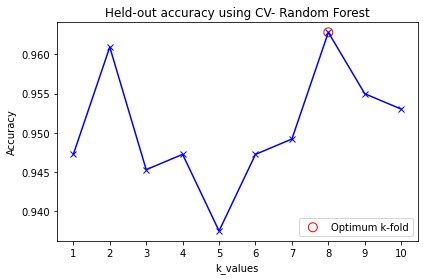

In [18]:
training.training_rf.plot_sensitivity_analysis(cv_accuracy)

The results suggest that perhaps k=2 is slightly optimistic and perhaps k=8 might be a more accurate estimate.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

###   Classifier: Random Forest

Training Models with Base Estimators

1. Training Model 1 Random Forest Classifier: Base Estimator , with 'max_depth', [1,5,10,20,50,100,200]

In [19]:
%%time
# Training Model 1 Random Forest Classifier: Base Estimator , with 'max_depth', [1,5,10,20,50,100,200]
rf_base1 = training.analysis.train_classifiers(sklearn.ensemble.RandomForestClassifier( random_state=0),
                                   X_train, y_train, 'max_depth', [1,5,10,20,50,100,200])

Wall time: 2.75 s


In [20]:
print("train:   ", training.analysis.score_classifiers(X_train, y_train, rf_base1))
print("test:    ", training.analysis.score_classifiers(X_test, y_test, rf_base1))

train:    [0.4684385382059801, 0.8030095759233926, 0.9507523939808481, 0.9998045729919874, 1.0, 1.0, 1.0]
test:     [0.46602827177382583, 0.7966256269949841, 0.9238486092111263, 0.9598723210214318, 0.9621523027815777, 0.9621523027815777, 0.9621523027815777]


2. Training Model 2 Random Forest Classifier: Base Estimator , 'n_estimators', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [21]:
%%time
# Training Model 2 Random Forest Classifier: Base Estimator , 'n_estimators', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
rf_base2 = training.analysis.train_classifiers(sklearn.ensemble.RandomForestClassifier( random_state=0),
                                   X_train, y_train, 'n_estimators', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] )

Wall time: 10.4 s


In [22]:
print("train:   ", training.analysis.score_classifiers(X_train, y_train, rf_base2))
print("test:    ", training.analysis.score_classifiers(X_test, y_test, rf_base2))

train:    [0.9658002735978112, 0.959937463357436, 0.9919874926714872, 0.998045729919875, 0.9998045729919874, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
test:     [0.9001367989056087, 0.8718650250797993, 0.9293205654354765, 0.9448244414044688, 0.9525763793889649, 0.958048335613315, 0.9621523027815777, 0.9635202918376653, 0.9644322845417237, 0.9635202918376653, 0.9635202918376653]


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

###   Classifier: Random Forest


##### Tuning Hyperparameters: Using Random search

In [23]:
rf, param_dist, cv, n_jobs, n_iter = training.training_rf.get_classifier_with_hyperparameters()

In [24]:
# Training Model : Random Forest 

# Fitting model
#Call random_search function
t0 = time.time() #initial time

rf_classifier = training.analysis.random_search(rf, X_train, y_train, param_dist,n_iter, cv, n_jobs, scoring = None)

print("Modeling time: %s" % time.strftime("%H:%M:%S", time.gmtime(time.time() - t0))) #to compute total time of the model


Fitting 8 folds for each of 1000 candidates, totalling 8000 fits
Modeling time: 00:09:50


In [25]:
training.analysis.print_performance_evaluation(catalogue, 
                                               'Random Forest',
                                               model = rf_classifier.best_estimator_,
                                               data = X_test, targets = y_test)

Model Performance of Classifier: Random Forest
Accuracy= 95.0296%.
Recall= 90.9379%.
Precision= 96.5954%.
macro-average ROC curve= 0.9983.


### Evaluate Performance of the Different Models Trained using Random Forest Estimator

In [26]:
#Evaluate Estimators Scores
print('Evaluate Estimators Base Scores of: ',rf.__class__.__name__)
estimators = [rf_base1[training.analysis.get_index_max_score_test(X_test, y_test, rf_base1)],# estimator 1 with different max_depth
              rf_base2[training.analysis.get_index_max_score_test(X_test, y_test, rf_base2)],# estimator 2 with different n_estimators
              rf_classifier]                                               # estimator 3 tunning hyperparamters with Random Searh
name_estimators = ["RFvsMaxDepht", "RFvsNestimators","RFvsCVRandomSearch"]

training.analysis.evaluate_score_estimators(catalogue,estimators,name_estimators, X_test, y_test)

Evaluate Estimators Base Scores of:  RandomForestClassifier


,RFvsMaxDepht,RFvsNestimators,RFvsCVRandomSearch
Accuracy,0.962152,0.964432,0.950296
Recall,0.947560,0.952426,0.909379
Precision,0.974264,0.976406,0.965954
macro-average ROC curve,0.998768,0.998946,0.998327


**Analysis**: Although, the second base estimator using RF where the model was trained using different n_estimators and we got the best performance with n_estimator = 256, the score of training set seems that the model is overfitting, that's why we decided to take the best model trained using RandomSearch given it uses CV, to avoid overfitting and it the scores are good!!

### Best Parameters of the best model trained with Random Forest 

Analysis of the best parameters from the best model with Random Forest Classifier: 

The best parameters using Random Seach are:

In [27]:
# Print the Best Estimator of the Classifier using Random Searh
print('Best Parameters of: ',rf.__class__.__name__)
training.plotting.print_best_parameters(model=rf_classifier)

Best Parameters of:  RandomForestClassifier
Parameter range:  {'n_estimators': 66, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}


<div style="border-bottom: 3px solid black;"></div>

#### Get features Importances 

Analysis:

We can see that the 10 variables that RF classifier are: 
1. ROLAUTO: "Role in car trip",  it means that the decision of the individuals to choice a mode of transport depends if is "Driver of car"."Passenger in car" or "No trip by car".
2. KAFSTV : "Distance class trip", this means that an individual choose a mode of transportation depending on the distance of their travels. 
3. AANTRIT: "Number of trip segments per day" , another influencing variable is the number of trips segments that an individual makes to reach their final destination using different modes of transport. 
4. KREISDUUR:"Travel duration class of trip", It means the duration of the intermediate trips that an individual makes to move from point A to point B. Since, usually, they use different modes of transport to move to their final destination. 
5. VERPL: "New trip", it means that if the new trip of the individual is a "regular occupational trip", "vacation trip", "trip abroad", etc.
6. KMOTIEF:"Classification of purpose", other important variable it what is the purpose of the trip of the individuals, such as: "To and from work", "Business-related visit in work context", "Services, personal care" , "Shopping, doing grocery shopping", "Following education study, courses" and "Touring, hiking"
7. GEBRUIK_FIETS_STELLING2 	: "I find cycling to be relaxing", these are the opinions of the individuals who consider using the bicycle as a means of transport so relaxing, the possible answers are: "strongly disagree","disagree do not agree", "do not disagree agree", "strongly agree" and "No opinion"
8. TOER_TYPE":	"Round trip type",  These are the trips that are round trip, and what was the purpose of that trip. It influences the decision of the mode of transport of the individuals depending on the purpose of the trip, such as:"A walking / running / cycling excursion" , "Mailing a letter","Multiple trips for work","Walking the dog"and "Picking up / dropping off people"
9. HHAUTO_N: "Number of cars in the household",Another influencing variable is the number of cars in the house
10. AANTVPL: "Number of trips per day" , another influencing variable is the number of total trips that an individual makes per day.

Saving figure Feature_Importance_Random_Forest


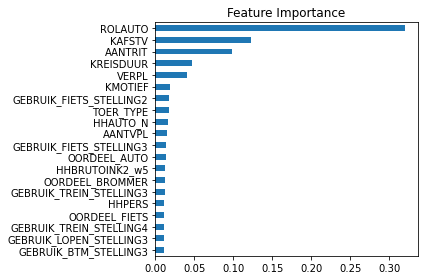

In [28]:
# call get_plot_features_importances function
training.plotting.get_plot_features_importances(model= rf_classifier.best_estimator_,data=data)
util.storage.save_fig("Feature_Importance_Random_Forest"); #call funcion "save_fig" to save the plot;

In [29]:
training.analysis.get_features_importances(catalogue, rf_classifier.best_estimator_, data)

,Feature,Description,Importance
0,ROLAUTO,Role in car trip,0.3201
1,KAFSTV,Distance class trip,0.1226
2,AANTRIT,Number of trip segments per day,0.0983
3,KREISDUUR,Travel duration class of trip,0.0474
4,VERPL,New trip,0.04
5,KMOTIEF,Classification of purpose,0.0194
6,GEBRUIK_FIETS_STELLING2,I find cycling to be relaxing,0.0178
7,TOER_TYPE,Round trip type,0.017
8,HHAUTO_N,Number of cars in the household,0.0159
9,AANTVPL,Number of trips per day,0.0144


#### Get Confusion Matrix

In [30]:
training.plotting.get_classification_report(catalogue, model=rf_classifier.best_estimator_,X_tst=X_test,y_tst=y_test);

Metrics:

Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.97
Macro Recall: 0.91
Macro F1-score: 0.93

Weighted Precision: 0.95
Weighted Recall: 0.95
Weighted F1-score: 0.95

Classification Report

                  precision    recall  f1-score   support

   Car as driver       1.00      1.00      1.00       610
Car as passenger       1.00      0.99      1.00       165
           Train       0.99      0.99      0.99       250
  Bus/tram/metro       0.98      1.00      0.99       248
   Scooter/moped       1.00      0.75      0.86        36
         Bicycle       0.88      0.91      0.90       463
         Walking       0.88      0.89      0.89       353
           Other       1.00      0.74      0.85        68

        accuracy                           0.95      2193
       macro avg       0.97      0.91      0.93      2193
    weighted avg       0.95      0.95      0.95      2193



Saving figure Confusion_Matrix_Random_Forest


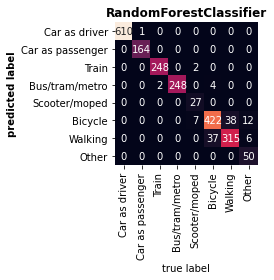

In [31]:
# call get_confusion_matrix function
training.plotting.get_confusion_matrix(catalogue, model=rf_classifier.best_estimator_,X_tst=X_test,y_tst=y_test)
util.storage.save_fig("Confusion_Matrix_Random_Forest") #call funcion "save_fig" to save the plot;

#### Get ROC Curve  - Multiclass predictions

AUC for class Car as driver: 1.00000
AUC for class Car as passenger: 1.00000
AUC for class Train: 0.99999
AUC for class Bus/tram/metro: 0.99996
AUC for class Scooter/moped: 0.99959
AUC for class Bicycle: 0.99039
AUC for class Walking: 0.99038
AUC for class Other: 0.99882
Saving figure ROC_CURVE_Random_Forest


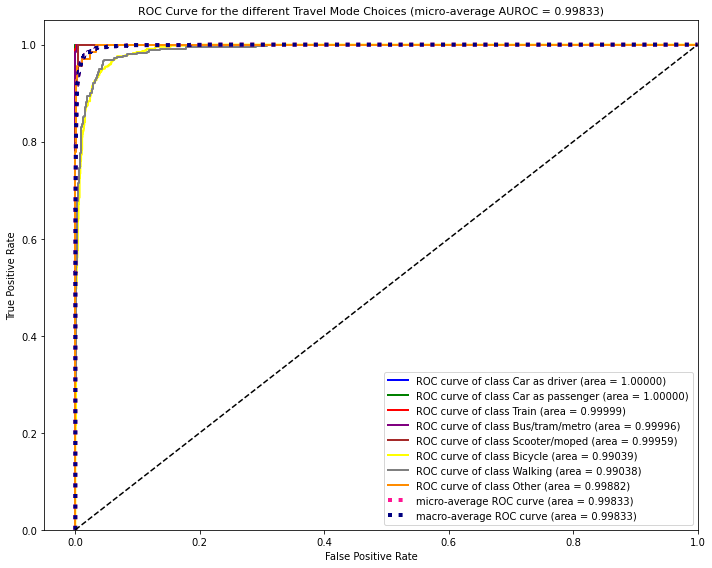

In [32]:
training.plotting.get_plot_roc_auc(catalogue, model=rf_classifier.best_estimator_
                 , X_features=X_test
                 , y_target=y_test)
util.storage.save_fig("ROC_CURVE_Random_Forest"); #call funcion "save_fig" to save the plot;;

#### Get Plot Precision-Recall curve for each class and iso-f1 curves

Saving figure PR_CURVE_Random_Forest


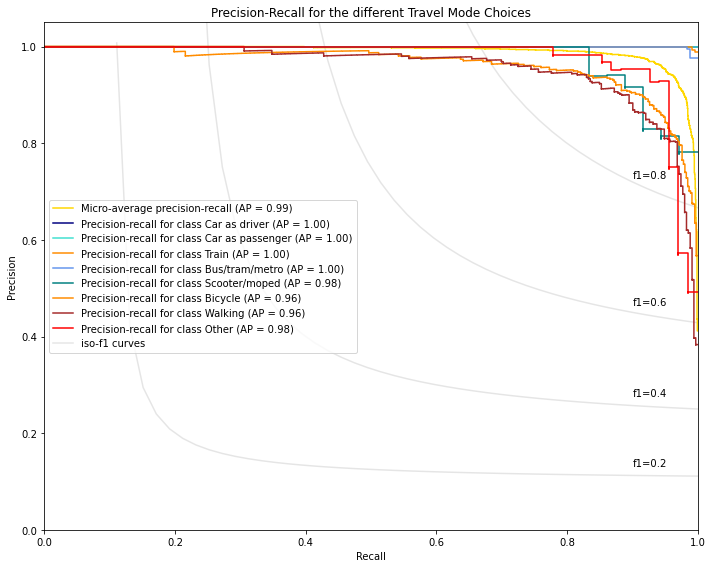

In [33]:
training.plotting.get_precision_recall_curve(catalogue,model=rf_classifier.best_estimator_
                 , X_features=X_test
                 , y_target=y_test)
util.storage.save_fig("PR_CURVE_Random_Forest");

# <div style="border-bottom: 3px solid black;"></div>

### 5.2 Multinomial Logistic Regression Model

#### Feature Scaling
In order to improve Logistic Regression model training. It needs to be scaled.

In [34]:
X_train_scaled, X_test_scaled = util.general.normalize_x(X_train, X_test)

##### Use K-fold cross-validation to estimate held-out performance

In [35]:
lr, accuracy_train, accuracy_test, cv_accuracy = training.training_lr.get_cross_validation(X_train_scaled, 
                                                                                           y_train,
                                                                                           X_test_scaled, 
                                                                                           y_test);

**Accuracy on Train and Held-out**
Training accuracy: 90.3%
Held-out accuracy (testing):  88.2%
held-out accuracy (2-fold): 88.7%
held-out accuracy (3-fold): 89.3%
held-out accuracy (4-fold): 88.5%
held-out accuracy (5-fold): 87.1%
held-out accuracy (6-fold): 86.5%
held-out accuracy (7-fold): 87.7%
held-out accuracy (8-fold): 90.4%
held-out accuracy (9-fold): 87.7%
held-out accuracy (10-fold): 88.1%


In [36]:
training.analysis.print_accuracy_cv(10, lr,X_train_scaled,y_train)

**Accuracy on Train and Held-out with CV**
held-out accuracy max (8- best fold): 90.4%


#### Sensitivity Analysis for k

Plot held-out accuracy using K-fold cross-validation the results for interpretation.

Saving figure Held-out-acc Multinomial Logistic Regression


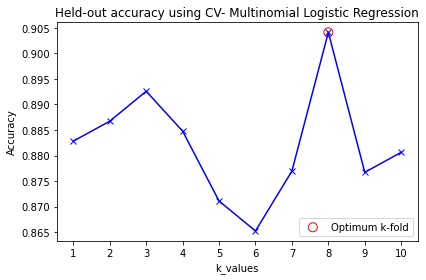

In [37]:
training.training_lr.plot_sensitivity_analysis(cv_accuracy)

The results shows that k=8 is the most accurate estimate using k-fold cross-validation.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

###   Classifier: Multinomial Logistic Regression

Training Models with Base Estimators

1. Training Model 1 Logistic Regression Classifier: Base Estimator , with 'C', [0.00001, 0.0001, 0.001, 0.01, 0.1]

In [38]:
%%time
# Training Model 1 Logistic Regression Classifier: Base Estimator , with 'C', [0.00001, 0.0001, 0.001, 0.01, 0.1]
lr_base1 = training.analysis.train_classifiers(sklearn.linear_model.LogisticRegression( random_state=0, solver='newton-cg'),
                                   X_train_scaled, y_train, 'C', [0.00001, 0.0001, 0.001, 0.01, 0.1])

Wall time: 2.18 s


In [39]:
print("train:   ", training.analysis.score_classifiers(X_train_scaled, y_train, lr_base1))
print("test:    ", training.analysis.score_classifiers(X_test_scaled, y_test, lr_base1))

train:    [0.27789720539378543, 0.4111784248583154, 0.7066640609732265, 0.8420949775258941, 0.8886066054328708]
test:     [0.2781577747378021, 0.4103967168262654, 0.7054263565891473, 0.8280893752849977, 0.8677610579115367]


1. Training Model 2 Logistic Regression Classifier: Base Estimator , with 'penalty', [‘none’, ‘l1’, ‘l2’, ‘elasticnet’]

In [40]:
%%time
# Training Model 2 Logistic Regression Classifier: Base Estimator , with 'penalty', [‘none’, ‘l2’]
lr_base2 = training.analysis.train_classifiers(sklearn.linear_model.LogisticRegression(random_state=0,solver='newton-cg'),
                                   X_train_scaled, y_train, 'penalty', ['none', 'l2'])

C:\Users\Brenda\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


Wall time: 29.1 s


In [41]:
print("train:   ", training.analysis.score_classifiers(X_train_scaled, y_train, lr_base2))
print("test:    ", training.analysis.score_classifiers(X_test_scaled, y_test, lr_base2))

train:    [0.9054133281219464, 0.9032636310338089]
test:     [0.8850889192886456, 0.8818969448244414]


##### Tuning Hyperparameters: Using Random search

In [42]:
lr, param_dist, cv, n_jobs, n_iter = training.training_lr.get_classifier_with_hyperparameters()

In [43]:
# Training Model : Multinomial Logistic Regression

# Fitting model
#Call random_search function
t0 = time.time() #initial time

lr_classifier = training.analysis.random_search(lr, X_train_scaled, y_train, param_dist,n_iter, cv, n_jobs, scoring = None)

print("Modeling time: %s" % time.strftime("%H:%M:%S", time.gmtime(time.time() - t0)))

Fitting 8 folds for each of 15 candidates, totalling 120 fits


C:\Users\Brenda\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 15 is smaller than n_iter=100. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Modeling time: 00:00:24


In [44]:
training.analysis.print_performance_evaluation(catalogue, 
                                               'Multinomial Logistic Regression',
                                               model = lr_classifier.best_estimator_,
                                               data = X_test_scaled, targets = y_test,average='micro')

Model Performance of Classifier: Multinomial Logistic Regression
Accuracy= 88.6457%.
Recall= 88.6457%.
Precision= 88.6457%.
micro-average ROC curve= 0.9925.


### Evaluate Performance of the Different Models Trained using Logistic Regression Estimator

In [45]:
#Evaluate Estimators Scores
print('Evaluate Estimators Base Scores of: ',lr.__class__.__name__)
estimators = [lr_base1[training.analysis.get_index_max_score_test(X_test_scaled, y_test, lr_base1)],# estimator 1 with different max_depth
              lr_base2[training.analysis.get_index_max_score_test(X_test_scaled, y_test, lr_base2)],# estimator 2 with different n_estimators
              lr_classifier]                                               # estimator 3 tunning hyperparamters with Random Searh
name_estimators = ["LR_C", "LR_Penalty","LR_CVRandomSearch"]

training.analysis.evaluate_score_estimators(catalogue,estimators,name_estimators, X_test_scaled, y_test)

Evaluate Estimators Base Scores of:  LogisticRegression


,LR_C,LR_Penalty,LR_CVRandomSearch
Accuracy,0.867761,0.885089,0.886457
Recall,0.784759,0.831943,0.835787
Precision,0.840980,0.854079,0.866768
macro-average ROC curve,0.990074,0.992373,0.992492


### Best Parameters of the best model trained with Logistic Regression

Analysis of the best parameters from the best model with Logistic Regression Classifier: 

The best parameters using Logistic Regression are:

In [46]:
# Print the Best Estimator of the Classifier using Random Searh
print('Best Parameters of: ',lr.__class__.__name__)
training.plotting.print_best_parameters(model=lr_classifier)

Best Parameters of:  LogisticRegression
Parameter range:  {'tol': 0.001, 'C': 10}


<div style="border-bottom: 3px solid black;"></div>

#### Get features Importances 

In [47]:
training.analysis.get_features_importances(catalogue, lr_classifier.best_estimator_, data)

,Feature,Description,Importance
0,ROLAUTO,Role in car trip,6.0395
1,KAFSTV,Distance class trip,0.5714
2,VERTRAGING,Trip delay (in minutes),0.5328
3,OORDEEL_AUTO,Personal impression of the car,0.5295
4,HHAUTO,Yes or no car in the household,0.4796
5,VERTREKP,Departure point 1st trip,0.3241
6,HHAUTO_N,Number of cars in the household,0.3043
7,N_KIND,Number of children <12 years old in the household,0.234
8,TOER,Departure point of trip is arrival point of tr...,0.2224
9,GEBRUIK_LOPEN_STELLING3,Walking saves me time,0.2186


Saving figure Feature_Importance_Multinomial_Logistic_Regression


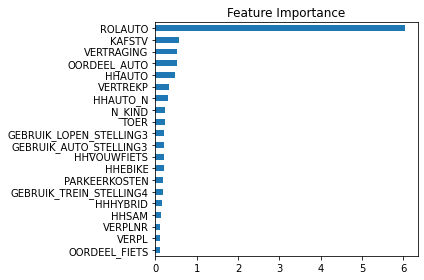

In [48]:
training.plotting.get_plot_features_importances(model= lr_classifier.best_estimator_,data=data)
util.storage.save_fig("Feature_Importance_Multinomial_Logistic_Regression")

#### Get Confusion Matrix

In [49]:
training.plotting.get_classification_report(catalogue, model=lr_classifier.best_estimator_,X_tst=X_test_scaled,y_tst=y_test)

Metrics:

Accuracy: 0.89

Micro Precision: 0.89
Micro Recall: 0.89
Micro F1-score: 0.89

Macro Precision: 0.87
Macro Recall: 0.84
Macro F1-score: 0.85

Weighted Precision: 0.89
Weighted Recall: 0.89
Weighted F1-score: 0.89

Classification Report

                  precision    recall  f1-score   support

   Car as driver       1.00      1.00      1.00       610
Car as passenger       1.00      1.00      1.00       165
           Train       0.87      0.88      0.87       250
  Bus/tram/metro       0.86      0.87      0.86       248
   Scooter/moped       0.88      0.78      0.82        36
         Bicycle       0.80      0.85      0.82       463
         Walking       0.82      0.78      0.80       353
           Other       0.72      0.53      0.61        68

        accuracy                           0.89      2193
       macro avg       0.87      0.84      0.85      2193
    weighted avg       0.89      0.89      0.89      2193



Saving figure Confusion_Matrix_Multinomial_Logistic_Regression


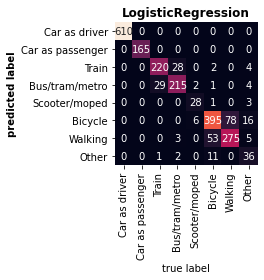

In [50]:
# call get_confusion_matrix function
training.plotting.get_confusion_matrix(catalogue, model=lr_classifier.best_estimator_,X_tst=X_test_scaled,y_tst=y_test)
util.storage.save_fig("Confusion_Matrix_Multinomial_Logistic_Regression") 

#### Get ROC Curve  - Multiclass predictions

AUC for class Car as driver: 1.00000
AUC for class Car as passenger: 1.00000
AUC for class Train: 0.99260
AUC for class Bus/tram/metro: 0.99119
AUC for class Scooter/moped: 0.99634
AUC for class Bicycle: 0.96898
AUC for class Walking: 0.97545
AUC for class Other: 0.94498
Saving figure ROC_CURVE_Multinomial_Logistic_Regression


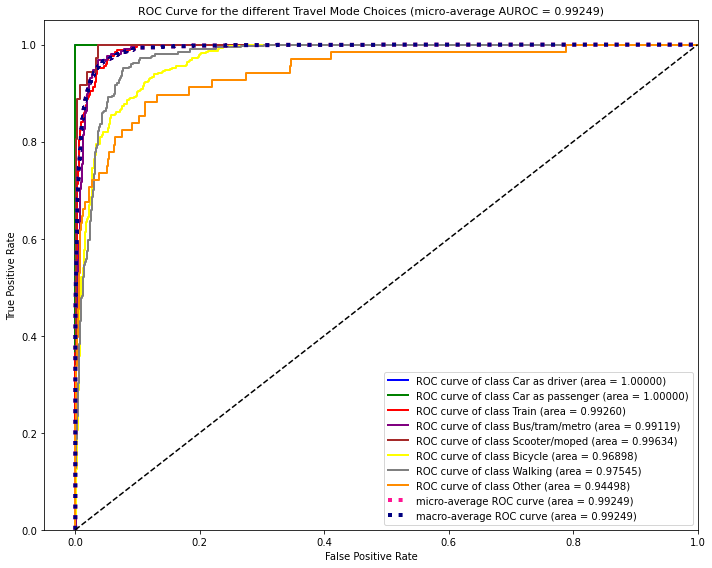

In [51]:
training.plotting.get_plot_roc_auc(catalogue, model=lr_classifier.best_estimator_
                 , X_features=X_test_scaled
                 , y_target=y_test)
util.storage.save_fig("ROC_CURVE_Multinomial_Logistic_Regression");

<div style="border-bottom: 3px solid black;"></div>

#### Get Plot Precision-Recall curve for each class and iso-f1 curves

Saving figure RECALL_CURVE_Multinomial_Logistic_Regression


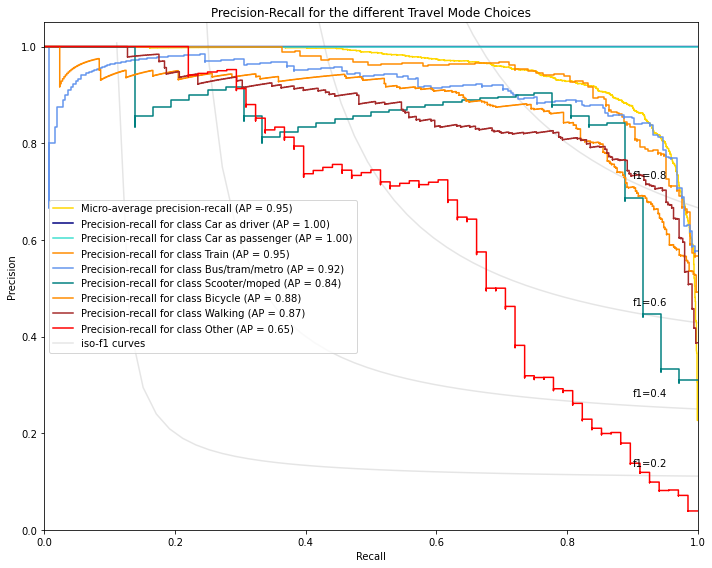

In [52]:
training.plotting.get_precision_recall_curve(catalogue, model=lr_classifier.best_estimator_
                 , X_features=X_test_scaled
                 , y_target=y_test)
util.storage.save_fig("RECALL_CURVE_Multinomial_Logistic_Regression");

# <div style="border-bottom: 3px solid black;"></div>

### 5.3 Support Vector Machines Model

##### Use K-fold cross-validation to estimate held-out performance

In [53]:
svm, accuracy_train, accuracy_test, cv_accuracy = training.training_svm.get_cross_validation(10, X_train, 
                                                                                           y_train,
                                                                                           X_test, 
                                                                                           y_test);

**Accuracy on Train and Held-out**
Training accuracy: 76.0%
Held-out accuracy (testing):  75.6%
held-out accuracy (2-fold): 73.6%
held-out accuracy (3-fold): 76.0%
held-out accuracy (4-fold): 73.8%
held-out accuracy (5-fold): 74.6%
held-out accuracy (6-fold): 72.5%
held-out accuracy (7-fold): 73.4%
held-out accuracy (8-fold): 76.3%
held-out accuracy (9-fold): 72.6%
held-out accuracy (10-fold): 75.7%


In [54]:
training.analysis.print_accuracy_cv(10, svm, X_train, y_train)

**Accuracy on Train and Held-out with CV**
held-out accuracy max (8- best fold): 76.3%


#### Sensitivity Analysis for k

Plot held-out accuracy using K-fold cross-validation the results for interpretation.

Saving figure Held-out-acc_SVM


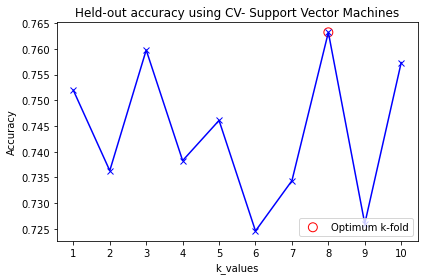

In [55]:
training.training_svm.plot_sensitivity_analysis(cv_accuracy)

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

###   Classifier: Support Vector Machines

Training Models with Base Estimators

In [56]:
%%time
# Training Model 1 SVM Classifier: Base Estimator , with 'C', [0.01, .1, 1, 10, 100, 1000]
svm_base1 = training.analysis.train_classifiers(sklearn.svm.SVC(kernel='rbf',
                                             random_state=0, 
                                             probability = True),
                                   X_train, y_train, 'C', [0.01, .1, 1, 10, 100, 1000])

Wall time: 36.8 s


In [57]:
print("train:   ", training.analysis.score_classifiers(X_train, y_train, svm_base1))
print("test:    ", training.analysis.score_classifiers(X_test, y_test, svm_base1))

train:    [0.27789720539378543, 0.520422122337307, 0.759624780144616, 0.8989642368575337, 0.9433261676763729, 0.9771350400625366]
test:     [0.2781577747378021, 0.5221158230734154, 0.7564979480164159, 0.8800729594163247, 0.9124487004103967, 0.937984496124031]


In [58]:
%%time
# Training Model 2 SVM Classifier: Base Estimator , solver: 'poly''gamma', ['auto', 1e-3, 1e-4]
svm_base2 = training.analysis.train_classifiers(sklearn.svm.SVC(kernel='rbf',
                                             random_state=0, 
                                             probability = True), 
                             X_train, y_train, 'gamma',  np.logspace(-2, 1, 4))

Wall time: 1min


In [59]:
print("train:   ", training.analysis.score_classifiers(X_train, y_train, svm_base2))
print("test:    ", training.analysis.score_classifiers(X_test, y_test, svm_base2))

train:    [0.9335548172757475, 0.9957006058237249, 1.0, 1.0]
test:     [0.8914728682170543, 0.8011855905152758, 0.4605563155494756, 0.41906064751481986]


In [60]:
%%time
# Training Model 3 SVM Classifier: Base Estimator , solver: 'poly', 'degree', [1, 2, 3, 4, 5, 6, 7, 8, 9]
svm_base3 = training.analysis.train_classifiers(sklearn.svm.SVC(kernel='poly',
                                             random_state=0, 
                                             probability = True),
                                   X_train, y_train, 'degree', [1, 2, 3, 4, 5, 6, 7, 8, 9])

Wall time: 28.4 s


In [61]:
print("train:   ", training.analysis.score_classifiers(X_train, y_train, svm_base3))
print("test:    ", training.analysis.score_classifiers(X_test, y_test, svm_base3))

train:    [0.7103771741254641, 0.7776040648817667, 0.8669142075434825, 0.8764901309360954, 0.892515145593121, 0.9001367989056087, 0.9114715653703341, 0.9247606019151847, 0.9360953683799101]
test:     [0.7118103055175559, 0.7733698130414957, 0.8590971272229823, 0.8650250797993616, 0.8723210214318285, 0.8787049703602371, 0.8873689010487916, 0.8992248062015504, 0.9074327405380757]


In [62]:
%%time
# Training Model 4 SVM Classifier: Base Estimator , different solvers ['linear', 'rbf','poly']
svm_base4 = training.analysis.train_classifiers(sklearn.svm.SVC(random_state=0, 
                                             probability = True),
                                   X_train, y_train, 'kernel' ,['linear', 'rbf','poly'])

Wall time: 15.4 s


In [63]:
print("train:   ", training.analysis.score_classifiers(X_train, y_train, svm_base4))
print("test:    ", training.analysis.score_classifiers(X_test, y_test, svm_base4))

train:    [0.9128395544264217, 0.759624780144616, 0.8669142075434825]
test:     [0.8937528499772002, 0.7564979480164159, 0.8590971272229823]


#### Training Scaled Data

In [64]:
X_train_scaled, X_test_scaled = util.general.normalize_x(X_train, X_test)

In [65]:
%%time

# Training Model 5 SVM Classifier: Base Estimator , with 'C', [0.01, .1, 1, 10, 100, 1000]
svm_base5 = training.analysis.train_classifiers(sklearn.svm.SVC(kernel='rbf',
                                             random_state=0, 
                                             probability = True),
                             X_train_scaled ,# X_scaled
                             y_train, 'C', [0.01, .1, 1, 10, 100, 1000])

Wall time: 34.2 s


In [66]:
print("train:   ", training.analysis.score_classifiers(X_train_scaled , y_train, svm_base5))
print("test:    ", training.analysis.score_classifiers(X_test_scaled , y_test, svm_base5))

train:    [0.28473715067422317, 0.774281805745554, 0.9620871604455736, 0.9937463357435997, 0.99921829196795, 1.0]
test:     [0.28454172366621067, 0.7583219334245326, 0.9124487004103967, 0.950296397628819, 0.9544003647970816, 0.9512083903328773]


In [67]:
# Training Model 4 SVM Classifier: Base Estimator , different solvers ['linear', 'rbf','poly']
svm_base6 = training.analysis.train_classifiers(sklearn.svm.SVC(random_state=0, 
                                             probability = True),
                                   X_train_scaled, y_train, 'kernel' ,['linear', 'rbf','poly'])

In [68]:
print("train:   ", training.analysis.score_classifiers(X_train_scaled , y_train, svm_base6))
print("test:    ", training.analysis.score_classifiers(X_test_scaled , y_test, svm_base6))

train:    [0.9136212624584718, 0.9620871604455736, 0.9230017588430721]
test:     [0.8969448244414044, 0.9124487004103967, 0.8905608755129959]


In [69]:
# Training Model 7 SVM Classifier: Base Estimator , different gamma :[ 0.01,  0.1 ,  1.  , 10.  ] and X_scaled
svm_base7 = training.analysis.train_classifiers(sklearn.svm.SVC(kernel='rbf',
                                             random_state=0, 
                                             probability = True),
                             X_train_scaled ,# X_scaled
                             y_train, 'gamma',  np.logspace(-2, 1, 4))

In [70]:
print("train:   ", training.analysis.score_classifiers(X_train_scaled , y_train, svm_base7))
print("test:    ", training.analysis.score_classifiers(X_test_scaled , y_test, svm_base7))

train:    [0.9317959742036349, 0.987297244479187, 0.9998045729919874, 1.0]
test:     [0.8914728682170543, 0.8901048791609667, 0.600547195622435, 0.41906064751481986]


In [71]:
#Evaluate Base Estimators Scores without X Scaled 

estimators= [svm_base1[training.analysis.get_index_max_score_test(X_test, y_test, svm_base1)],
             svm_base2[training.analysis.get_index_max_score_test(X_test, y_test, svm_base2)],
             svm_base3[training.analysis.get_index_max_score_test(X_test, y_test, svm_base3)],
             svm_base4[training.analysis.get_index_max_score_test(X_test, y_test, svm_base4)]]                                               # estimator 3 tunning hyperparamters with Random Searh
name_estimators = ["SVM_rbfvsC", "SVM_rbfvsGamma",
                   "SVM_polivsdegree","SVMvsKernels" ]

training.analysis.evaluate_score_estimators(catalogue,estimators,name_estimators, X_test, y_test)

,SVM_rbfvsC,SVM_rbfvsGamma,SVM_polivsdegree,SVMvsKernels
Accuracy,0.937984,0.891473,0.907433,0.893753
Recall,0.931415,0.786129,0.843231,0.863410
Precision,0.929119,0.885302,0.861591,0.862586
macro-average ROC curve,0.997354,0.994343,0.980403,0.993603


In [72]:
#Evaluate Base Estimators Scores with X Scaled 

estimators2= [svm_base5[training.analysis.get_index_max_score_test(X_test_scaled, y_test, svm_base5)],
             svm_base6[training.analysis.get_index_max_score_test(X_test_scaled, y_test, svm_base6)]]                                               # estimator 3 tunning hyperparamters with Random Searh
name_estimators = ["SVM_rbfvsC_XScaled","SVMvsKernels_XScaled"]

training.analysis.evaluate_score_estimators(catalogue, estimators2,name_estimators, X_test_scaled, y_test)

,SVM_rbfvsC_XScaled,SVMvsKernels_XScaled
Accuracy,0.954400,0.912449
Recall,0.952154,0.868688
Precision,0.961098,0.917608
macro-average ROC curve,0.998765,0.996921


Conclusion: SVM is sensitive to unscale features, that's why we will tune hyperparameters using X scaled and 'RBF' Kernel; 'RBF'  had better performance.

##### Tuning Hyperparameters: Using Random search

In [73]:
svm, param_dist, cv, n_jobs, n_iter = training.training_svm.get_classifier_with_hyperparameters()

In [74]:
# Training Model : SVM

# Fitting model
#Call random_search function
t0 = time.time() #initial time

svm_classifier = training.analysis.random_search(svm, X_train_scaled, y_train, param_dist,n_iter, cv, n_jobs, scoring = None)

print("Modeling time: %s" % time.strftime("%H:%M:%S", time.gmtime(time.time() - t0)))

Fitting 8 folds for each of 24 candidates, totalling 192 fits
Modeling time: 00:18:20


In [75]:
training.analysis.print_performance_evaluation(catalogue, 
                                               'SVM',
                                               model = svm_classifier.best_estimator_,
                                               data = X_test_scaled, targets = y_test)

Model Performance of Classifier: SVM
Accuracy= 95.9872%.
Recall= 95.9457%.
Precision= 96.6904%.
macro-average ROC curve= 0.9986.


### Choosing the best model trained with SVM

In [76]:
#Evaluate Base Estimators Scores with X Scaled 
print('Evaluate Estimators Base Scores of: ',svm.__class__.__name__)
estimators= [svm_base5[training.analysis.get_index_max_score_test(X_test_scaled, y_test, svm_base5)],
             svm_base6[training.analysis.get_index_max_score_test(X_test_scaled, y_test, svm_base6)],
             svm_classifier]

# Comparing the 3 SVM Estimators 
name_estimators = ["SVM_rbfvsC_XScaled","SVMvsKernels_XScaled", "SVMvsCVRandomSearch_XScaled"]

training.analysis.evaluate_score_estimators(catalogue,estimators,name_estimators, X_test_scaled, y_test)

Evaluate Estimators Base Scores of:  SVC


,SVM_rbfvsC_XScaled,SVMvsKernels_XScaled,SVMvsCVRandomSearch_XScaled
Accuracy,0.954400,0.912449,0.959872
Recall,0.952154,0.868688,0.959457
Precision,0.961098,0.917608,0.966904
macro-average ROC curve,0.998765,0.996921,0.998597


Analysis:
We can see that the best estimator using SVM was SVM using Random Search; 

### Best Parameters of the best model trained with SVM

In [77]:
# Print the Best Estimator of the Best Classifier using Random Searh
print('Best Estimator of the Classifier:',svm.__class__.__name__)
training.plotting.print_best_parameters(model=svm_classifier)

Best Estimator of the Classifier: SVC
Parameter range:  {'gamma': 0.01, 'C': 100}


### Confusion Matrix of the best model trained with SVM

In [78]:
training.plotting.get_classification_report(catalogue,model=svm_classifier.best_estimator_,X_tst=X_test_scaled,y_tst=y_test);

Metrics:

Accuracy: 0.96

Micro Precision: 0.96
Micro Recall: 0.96
Micro F1-score: 0.96

Macro Precision: 0.97
Macro Recall: 0.96
Macro F1-score: 0.96

Weighted Precision: 0.96
Weighted Recall: 0.96
Weighted F1-score: 0.96

Classification Report

                  precision    recall  f1-score   support

   Car as driver       0.99      1.00      1.00       610
Car as passenger       1.00      0.98      0.99       165
           Train       1.00      1.00      1.00       250
  Bus/tram/metro       1.00      1.00      1.00       248
   Scooter/moped       0.95      1.00      0.97        36
         Bicycle       0.92      0.90      0.91       463
         Walking       0.88      0.91      0.89       353
           Other       1.00      0.88      0.94        68

        accuracy                           0.96      2193
       macro avg       0.97      0.96      0.96      2193
    weighted avg       0.96      0.96      0.96      2193



Saving figure Confusion_Matrix_SVM


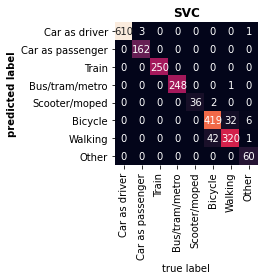

In [79]:
# call get_confusion_matrix function
training.plotting.get_confusion_matrix(catalogue,model=svm_classifier.best_estimator_,X_tst=X_test_scaled,y_tst=y_test)
util.storage.save_fig("Confusion_Matrix_SVM") #call funcion "save_fig" to save the plot;

#### Get ROC Curve  - Multiclass predictions

AUC for class Car as driver: 0.99999
AUC for class Car as passenger: 0.99999
AUC for class Train: 1.00000
AUC for class Bus/tram/metro: 1.00000
AUC for class Scooter/moped: 0.99995
AUC for class Bicycle: 0.98914
AUC for class Walking: 0.98713
AUC for class Other: 0.99833
Saving figure ROC_CURVE_SVM


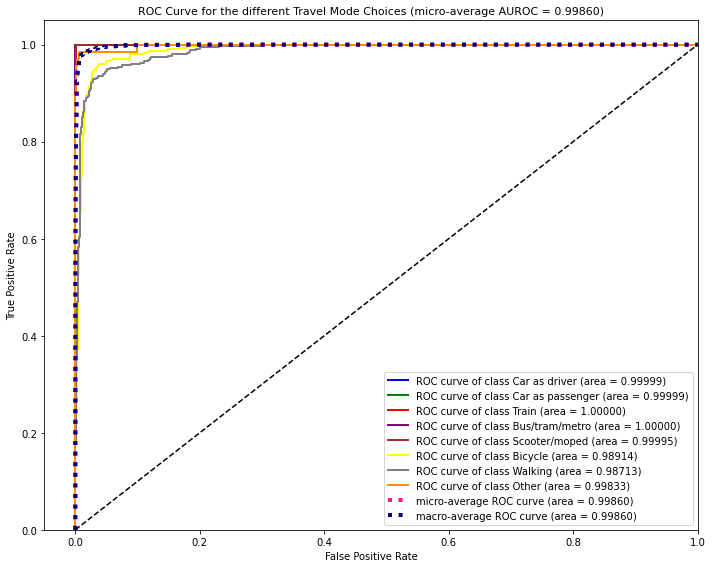

In [80]:
training.plotting.get_plot_roc_auc(catalogue, model=svm_classifier.best_estimator_
                 , X_features=X_test_scaled
                 , y_target=y_test)
util.storage.save_fig("ROC_CURVE_SVM");

#### Get Plot Precision-Recall curve for each class and iso-f1 curves

Saving figure RECALL_CURVE_SVM


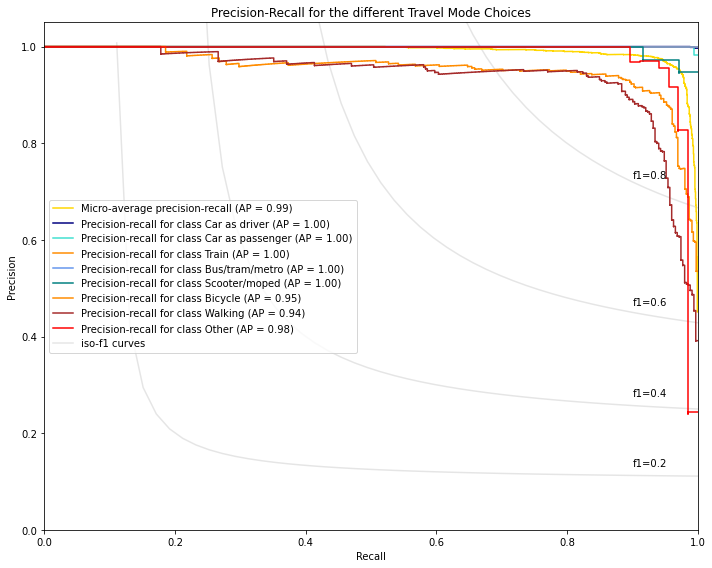

In [81]:
training.plotting.get_precision_recall_curve(catalogue, model=svm_classifier.best_estimator_
                 , X_features=X_test_scaled
                 , y_target=y_test)
util.storage.save_fig("RECALL_CURVE_SVM");

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>


### Classifiers : Choosing the Final Model -  Presentation

**Table 1**: Comparison of the performances of the used classifiers

In [82]:
score_lr = training.analysis.evaluate_score_estimators(catalogue,[lr_classifier],["LR"], X_test_scaled, y_test) 
score_rf = training.analysis.evaluate_score_estimators(catalogue,[rf_classifier],["RF"], X_test, y_test)
score_svm = training.analysis.evaluate_score_estimators(catalogue,[svm_classifier],["SVM"], X_test_scaled, y_test)
result = pd.concat([score_lr,score_rf,score_svm ], axis=1)
result

,LR,RF,SVM
Accuracy,0.886457,0.950296,0.959872
Recall,0.835787,0.909379,0.959457
Precision,0.866768,0.965954,0.966904
macro-average ROC curve,0.992492,0.998327,0.998597


**Analysis**: Table 1 shows a comparison of the metrics of the performances
Overall, SVM had a better performance which increases the accuracy, recall, precision and macro-average of the prediction.

**Figure 2**: Comparison of Confusion Matrix by the different classifiers

Saving figure Classifiers_Confusion_Matrix


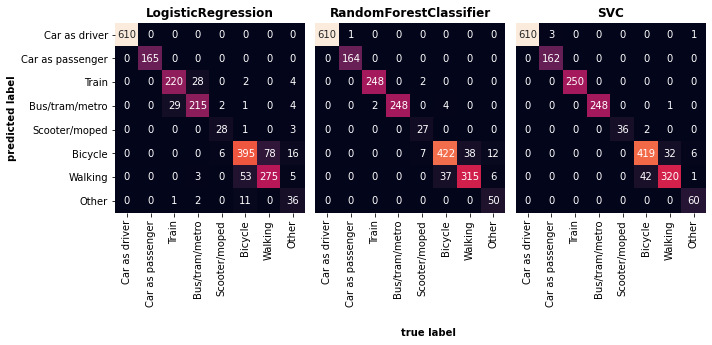

In [83]:
training.plotting.get_summary_confusion_matrices(catalogue,lr_classifier, svm_classifier,rf_classifier,
                                                X_test, X_test_scaled,y_test)

**Analysis** :the figure above shows the confusion matrix obtained from each method applied. 
We can see how each method predicts each class, overall SVM predicts better each class.

**Table 2**: Comparison of the prediction ability

In [84]:
prediction_classifiers = training.analysis.get_predictions_classifiers(lr_classifier, rf_classifier, svm_classifier, X_test,X_test_scaled) 
training.plotting.get_comparison_predictions_ability(catalogue,prediction_classifiers, y_test)

Comparison of the prediction ability - Predicted Recall (TPR)


,LR,RF,SVM
Car as driver,100.00,100.00,100.00
Car as passenger,100.00,99.39,98.18
Train,88.00,99.20,100.00
Bus/tram/metro,86.69,100.00,100.00
Scooter/moped,77.78,75.00,100.00
Bicycle,85.31,91.14,90.50
Walking,77.90,89.24,90.65
Other,52.94,73.53,88.24


**Analysis**:  Table 2 summarizes the True Positive Rates (TPR) overall and for each class, for instance, we can see that to Logistic Regression and Random Forest, the hardest class to predict were “Scooter/moped” and “Other” class.

**Table 3**: Comparison the proportion of travel choices of travelers in the overall data set and predict share with LR,RF, and SVM

In [85]:
training.plotting.get_comparison_proportions_and_predictions(catalogue,
                                                             data,
                                                             prediction_classifiers,
                                                             y_test)

Comparison the proportion of travel choices of travelers in the overall data set and predict share with LR,RF, and SVM


,Actual Share%,Predicted Share LR%,Predicted Share RF%,Predicted Share SVM%,LR error%,RF error%,SVM error%
Car as driver,27.80,31.38,29.27,28.98,12.88,5.30,4.25
Car as passenger,7.52,8.49,7.87,7.70,12.81,4.59,2.29
Train,11.41,11.32,11.90,11.88,-0.81,4.31,4.10
Bus/tram/metro,11.30,11.06,11.90,11.78,-2.12,5.32,4.26
Scooter/moped,1.64,1.44,1.30,1.71,-12.26,-21.08,4.18
Bicycle,21.12,20.32,20.25,19.90,-3.80,-4.13,-5.76
Walking,16.11,14.15,15.12,15.20,-12.22,-6.20,-5.67
Other,3.09,1.85,2.40,2.85,-40.10,-22.40,-7.80


**Analysis** The above table compares the proportion of travel mode choices of travellers in the overall data set and predicts the share of each method applied. 
SVM shows in overall less percentage error of predicted share.

In overall, the results show that the best-performing machine-learning model was the SVM method.

**Table 4: Conclusions:***

In [86]:
training.plotting.get_variation_percentage(score_lr,score_rf,score_svm)

The variation percentage


,LR,RF,SVM,Var% SVM vs LR,Var% SVM vs RF
Accuracy,0.89,0.95,0.96,8.28,1.01
Recall,0.84,0.91,0.96,14.80,5.51
Precision,0.87,0.97,0.97,11.55,0.10
macro-average ROC curve,0.99,1.00,1.00,0.62,0.03


Advantages:

1. Random Forest and SVM perform best, with high accuracy.
2. We noted that overall SVM was not significantly better than Random Forest; for instance, the recall metric improved 5%, and the improvement was not greater than 1% in the other metrics.
3. Random Forest: this ML method shows the variable importance. This score is useful given we could choose the most important features and drop the least important ones.
4. Random Forest is also computationally lighter than SVM method

Disadvantages:

1. Random Forest: the model is difficult to interpret, given it has multiple decision trees, and it is not easy deciding by following one path.  
2. SVM: Using the “RBF” kernel, we cannot get the importance of each explanatory variable, for that is better to use the “Linear” kernel, but the cost of processing time and performance is better using the “RBF” instead of “Linear” kernel.
3. Multinomial Logistic Regression: the performance of this method was good; however, it is susceptible to unbalanced classes. Furthermore, it could not predict the classes with a lower ratio than the other classes very well.
